![Codenation](https://forum.codenation.com.br/uploads/default/original/2X/2/2d2d2a9469f0171e7df2c4ee97f70c555e431e76.png)

__Autor__: Kazuki Yokoyama (kazuki.yokoyama@ufrgs.br)

# Classificação

![cover](https://cdn.app.compendium.com/uploads/user/e7c690e8-6ff9-102a-ac6d-e4aebca50425/f0499405-1197-4b43-b7c5-40548eeb9f34/Image/3b3ca365c0a481a5fa29437947107aaf/machine_learning_classification_graph.png)

Neste módulo, falaremos sobre classificação, uma das principais tarefas (junto da regressão) de aprendizado supervisionado. Será apresentado o problema geral de classificação, a matriz de confusão, a curva ROC, como trabalhar com _data sets_ desbalanceados e algumas técnicas comuns de classificação binária como regressão logística, kNN, árvores de decisão e _random forests_.

## Importação das bibliotecas

In [42]:
import functools
from math import sqrt

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import scipy.stats as sct
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.datasets import make_blobs, make_classification
from sklearn.decomposition import PCA
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [43]:
# Algumas configurações para o matplotlib.
#%matplotlib inline

from IPython.core.pylabtools import figsize


figsize(12, 12)

In [44]:
np.random.seed(1000)

In [45]:
def visualize_classifier(model, X, y, ax=None, cmap='rainbow'):
    ax = ax or plt.gca()
    
    # Plot the training points
    ax.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap=cmap,
               clim=(y.min(), y.max()), zorder=3)
    ax.axis('tight')
    ax.axis('off')
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # Predict
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with the results
    n_classes = len(np.unique(y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3,
                           levels=np.arange(n_classes + 1) - 0.5,
                           cmap=cmap, #clim=(y.min(), y.max()),
                           zorder=1)

    ax.set(xlim=xlim, ylim=ylim)



## O problema da classificação

Em poucas palavras, o problema da classificação pode ser descrito como a tarefa de atribuir uma classe ou categoria (_label_) a uma certa observação de dados (_data point_). Para isso, utilizamos um conjunto de dados anotado (_labeled_), ou seja, dados que já foram previamente classificados ou categorizados, para treinar um classificador (modelo probabilístico ou algorítmico capaz de atribuir classes a dados).

Os dados de treinamento devem ser devidamente anotados (classificados) com suas corretas classes. Esse processo pode ser manual, onde pessoas observam o dado e o classificam, ou mesmo automático, onde o processo que gera os dados é previamente conhecido e é usado para já anotar os dados gerados. Também precisamos de dados anotados para avaliar a performance do modelo treinado, ou seja, o conjunto de teste ou validação também deve ser corretamente anotado.

O tipo mais básico de classificação envolve duas classes, que podemos chamar de classe positiva e classe negativa (o que significa ser positivo ou negativo depende da semântica do problema). Esse tipo de tarefa é chamada de classificação binária. Por exemplo, podemos ter a tarefa de classificar dados de sensores em duas classes: normal ou defeituoso. Nesse cenário, como estamos interessados em encontrar os "defeituosos", pode ser interessante considerar a classe positiva como sendo os "defeituosos", enquanto a classe de funcionamento normal é considerada negativa (sem defeito).

Outros tipos mais gerais de classificação envolvem $k$ classes. Esse tipo de tarefa é chamada classificação multiclasse. Um exemplo imediato é a classificação das plantas do _data set_ Iris em suas devidas espécies dentre as três possíveis (setosa, virginica e versicolor).

De um ponto de vista geométrico, o problema da classificação pode ser vista como a tarefa de se traçar fronteiras de decisão (_decision boundaries_) entre as regiões que caracterizam cada classe. Classificamos um novo ponto observando a classe da região onde ele se encontra.

![decision-boundary](https://miro.medium.com/max/1012/1*i_oYgWjPbXbg3Z2uQLAmtw.png)

Na figura acima, temos duas classes, representadas pelas cores azul e verde. Um determinado classificador traçou a fronteira de decisão mostrada em azul entre as duas classes, separando o espaço de _features_ em duas regiões.

Para o classificador, todos os pontos acima da fronteira são considerados como sendo da classe azul, enquanto  todos os pontos abaixo da fronteira são considerados como sendo da classe verde. Note como alguns pontos realmente verdes encontram-se acima da fronteira. Obviamente, o classificador comete erros.

Cada diferente tipo de acerto e erro de um classificador recebe um nome e podemos derivar algumas métricas de avaliação de um classficador a partir deles. Para um classificador binário (pode ser estendido a um classificador multiclasse também), podemos construir uma matriz de confusão, que sumariza os acertos e erros de um classificador.

## Matriz de confusão

A matriz de confusão nada mais é que uma representação tabular dos acertos e erros de um classificador. Nela, sumarizamos as quantidades de pontos que foram corretamente classificados e os que não foram.

> Discutimos aqui a matriz de confusão para o caso da classificação binária. Para o cenário multiclasse também é possível definir matriz de confusão, mas isso não será mostrado aqui.

> A definição abaixo da matriz de confusão é uma dentre as possíves. Alguns autores utilizam a definição "transposta" da dada abaixo. Isso não faz muita diferença, senão atrapalhar a memorização.

A matriz de confusão possui duas linhas e duas colunas. As linhas são relativas aos valores verdadeiros, aqueles anotados no _data set_. As colunas são relativas aos valores previstos pelo modelo:

![confusion-matrix](https://drive.google.com/uc?export=download&id=1Li5Ep-5PRpua2vtQLXHvltaeGsr-lftZ)

O modelo pode cometer dois tipos de erros, similar aos testes de hipóteses da estatística:

1. O primeiro tipo de erro é o falso positivo ($FP$): dizer que o dado pertence à classe positiva, quando na verdade pertence à classe negativa. Isso seria um Erro Tipo I.
2. O segundo tipo de erro é o falso negativo ($FN$): dizer que o dado pertence à classe negativa, quando na verdade pertence à classe positiva. Isso seria um Erro Tipo II.

Observando a matriz de confusão, fica claro que desejamos minimizar $FP$ e $FN$ e maximizar $TP$ e $TN$. Em muitos casos, isso não será totalmente possível, e dependendo da aplicação, devemos priorizar a minimização dos $FP$ ou dos $FN$.


Cada um dos oito tipos de métrica derivados da matriz de confusão recebe um nome, segundo é mostrado abaixo:

![confusion-matrix-metrics](https://drive.google.com/uc?export=download&id=1GUQs3pT07UJVGTINPNEHE0ACrr1_FYOk)

Cada métrica uma razão entre o valor de um dos quadrantes e a soma desse quadrante com um adjacente a ele.

Por exemplo, _precision_ (em vermelho) é definida como:

$$\text{precision} = \frac{TP}{TP + FP}$$

O _fall-out_ (em amarelo) é definido como:

$$\text{fall-out} = \frac{FP}{FP + TN}$$

O _recall_ (em azul) é definido como:

$$\text{recall} = \frac{TP}{TP + FN}$$

Note que existem certas relações entre as métricas, por exemplo:

$$\text{fall-out} + \text{specificity} = \frac{FP}{FP + TN} + \frac{TN}{TN + FP} = \frac{FP + TN}{FP + TN} = 1 \Rightarrow \text{fall-out} = 1 - \text{specificity}$$

Outras métricas importantes também podem ser derivadas:

$$\text{accuracy} = \frac{TP + TN}{P + N}$$

onde $P$ são os realmente positivos (_actual positive_) e $N$ são os realmente negativos (_actual negative_).

O $F_{1}$-_score_ é a média harmônica entre _precision_ e _recall_:

$$F_{1} = \frac{2 \times \text{precision} \times \text{recall}}{\text{precision} + \text{recall}}$$

## ROC

A curva ROC (_Receiver Operating Curve_) é uma outra forma de avaliar o desempenho de classificadores. Sua origem remonta às telecomunicações, por isso o nome histórico.

O ROC é um gráfico cartesiano onde no eixo x encontra-se a métrica de _fall-out_ (ou _False Positive Ratio_ - FPR) e no eixo y a métrica de _recall_ (_sensitivity_ ou _True Positive Ratio_ - TPR):

![roc](https://upload.wikimedia.org/wikipedia/commons/thumb/3/36/ROC_space-2.png/1024px-ROC_space-2.png)

Basicamente, o ROC é um gráfico do _trade-off_ existente entre erros (representado pelo _fall-out_) e acertos (representado pelo _recall_) para diferentes fronteiras de decisão de um classificador.

A fronteira de decisão aqui pode ser, por exemplo, o _threshold_ de probabilidade que separa a classe negativa da classe positiva. Se a saída de um classificador é a probabilidade do dado ser da classe positiva, valores de saída abaixo do _threshold_ significam que o dado será previsto como sendo da classe negativa; valores de saída acima do _threshold_ significam que o dado será previsto como sendo da classe positiva. Por exemplo, uma probabilidade igual a 0.6 de ser da classe positiva significa considerar o dado como sendo da classe positiva para um _threshold_ igual a 0.3, mas não para um _threshold_ igual a 0.8.

Diferentes níveis de _threshold_ levam a diferentes números de acertos e erros e consequentemente a diferentes valores para _fall-out_ e _recall_. O ROC captura esses diferentes pares de valores para cada nível de _threshold_.

Idealmente, um classificador deveria ter sempre um único ponto no ROC: $(0, 1)$. Isso significaria que o classificador é capaz de identificar um dado da classe positiva 100% das vezes ($\text{recall} = 1$) e nunca classificaria um dado da classe negativa como sendo da classe positiva ($\text{fall-out} = 0$). Infelizmente, isso nunca acontece.

O que observamos no entanto é uma curva que vai de $(0, 0)$ (nenhum dado é previsto como sendo da classe negativa) a $(1, 1)$ (nenhum dado é previsto como sendo da classe positiva). Isto é, começamos com um valor de _threshold_ zero e o aumentamos até um.

O classificador trivial (_random guess_) é um classificador que faz classificações aleatórias, tão somente baseadas nas proporções de dados da classe negativa e positiva no _data set_. O seu desempenho é capturado pela curva $y = x$ no ROC.

Como queremos ter um modelo que seja melhor que o classificador aleatório, devemos buscar um classificador cujo ROC seja uma curva sempre acima da reta $y = x$. Curvas abaixo da reta $y = x$ significam que o classificador se comporta pior do que chutes aleatórios sobre as classes.

Analisando a figura do ROC acima, vemos que o ponto _A_ representa um desempenho melhor que do classificador aleatório, ao passo que _B_ representa o desempenho esperado de um classificador aleatório e _C_ um classificador pior do que chutes aleatórios. O ponto _C'_ representa o melhor desempenho dos quatro: ele não só está acima da reta $y = x$, como ele possui um _recall_ maior que _A_ e um _fall-out_ menor.

Apesar de visualmente ser fácil avaliar o desempenho de um classificador usando a curva ROC, é difícil comparar o desempenho geral de múltiplos classificadores. Uma forma de sumarizar o desempenho do classificador usando o ROC é através da área embaixo da curva ROC: AUC (_Area Under Curve_).

![auc](https://miro.medium.com/max/722/1*pk05QGzoWhCgRiiFbz-oKQ.png)

A AUC do ROC é uma métrica que vai de 0 a 1. Quanto mais próximo de 1, melhor é o desempenho geral do classificador.

Comparar classificadores com AUC é uma tarefa trivial: o classificador com maior AUC possui o melhor desempenho geral. É fácil ver que a AUC de um classificador aleatório é 0.5, logo qualquer classificador com AUC superior a 0.5 é um classificador melhor do que chutes aleatórios.



## Dados desbalanceados

Voltando ao problema da classificação, é comum nos depararmos com _data sets_ onde uma classe representa a maioria dos dados, enquanto as outras são minorias. Chamamos esses conjuntos de _imbalanced data sets_.

Isso não é incomum. Considere por exemplo dados de fraudes em cartões de crédito. Uma parcela dos dados realmente representa transações fraudulentas (a classe positiva: houve fraude). Porém, uma parcela muito maior representa as transações onde não houve qualquer tipo de fraude (a classe negativa: nenhuma fraude).

Eles representam um problema porque os classificadores aprendem, espertamente, que podem prever um dado como sendo da classe majoritária sempre, e ainda assim o classificador terá "bom desempenho". Por exemplo, considere o caso onde a classe A, majoritária, representa 98% do _data set_, enquanto a classe B, minoritária, representa apenas 2%. Se o classificador sempre classificar um novo dado como sendo da classe A, ele acertará, no conjunto de treino, 98% das vezes. Claro que esse bom desempenho é ilusório.

Para realizarmos classificação com dados desbalanceados, devemos balanceá-los primeiro. As técnicas mais comuns para balanceamento de dados é através de reamostragem (_resampling_). Isso pode ser feito de duas formas básicas:

* _Undersampling_: removemos dados da classe majoritária;
* _Oversampling_: reamostramos dados da classe minoritária;

Qualquer uma das duas formas pode ser feita de forma aleatória (e.g., removemos dados aleatórios da classe majoritária durante _undersampling_) ou seguindo uma heurística mais sofisticada. Aqui focaremos no SMOTE (_Synthetic Minority Oversampling Technique_), uma técnica de _oversampling_ que adiciona dados sintéticos da classe minoritária ao conjunto de dados.

## SMOTE

SMOTE é uma das técnicas mais populares de reamostragem em casos de classes desbalanceadas. Trata-se de uma técnica de _oversampling_ que adiciona dados sintéticos à classe minitoritária através de uma heurística relativamente simples.

![smote](https://raw.githubusercontent.com/rafjaa/machine_learning_fecib/master/src/static/img/smote.png)

1. Para cada ponto $p_{i}$ da classe minoritária, o SMOTE encontra seus $k$ vizinhos mais próximos.
2. Para cada um dos $k$ vizinhos mais próximos de $p_{i}$ (i.e., $p_{i1}, p_{i2}, \cdots, p_{ik}$), é adicionado um novo ponto, $p'_{ij}$ ($j = 1, 2, \cdots, k$), na reta que liga $p_{i}$ e $p_{ij}$, a uma distância aleatória de $p_{i}$.
3. Repete-se esse processo até que o número de novos pontos sintéticos seja satisfatório.

O SMOTE pode ser pensado como um _oversampling_ aleatório adicionado de uma perturbação direcionada. Isso evita os problemas de _overfitting_ existentes no _oversampling_ aleatório simples.

Esse algoritmo não está disponível por padrão no sklearn, mas pode ser encontrado nos seus projetos de contribuição na biblioteca `imblearn`.

Considere o exemplo abaixo:

In [46]:
X_data, y_data = make_classification(n_samples=1000,
                                     n_features=10,
                                     n_informative=10,n_redundant=0,
                                     n_repeated=0,
                                     weights=(0.1, 0.9),
                                     n_clusters_per_class=1,
                                     class_sep=3.0)

imbalanced = pd.DataFrame(np.c_[X_data, y_data], columns=["X" + str(i) for i in range(1, 11)] + ["target"])

imbalanced.target = imbalanced.target.astype(bool)

In [47]:
imbalanced.iloc[:5, :-1]

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10
0,2.264019,-5.879977,-0.262661,1.137353,-1.635105,-2.531767,5.789418,-0.951279,2.643438,-0.831458
1,1.829764,-5.209499,2.999197,2.290076,-3.010978,-4.402686,0.908426,-3.332957,3.722355,0.615578
2,1.350631,-5.069955,3.869841,2.523473,-4.199743,-6.161144,0.800673,-1.716646,5.273588,2.746047
3,0.897472,-4.894522,1.861834,3.581587,-2.396599,-6.604574,2.122387,-2.099819,1.930993,1.464681
4,2.399397,-1.858286,5.391069,3.715560,-4.269411,-4.255609,0.762214,-3.168513,6.155921,4.429450


Por construção, existem muito mais dados da classe positiva do que da classe negativa (uma proporção 9:1):

Para visualizar os dados, que estão em $\mathbb{R}^{10}$, utilizamos PCA e os transformamos para $\mathbb{R}^{2}$:

In [49]:
pca = PCA(n_components=2)

pca.fit(imbalanced.drop(["target"], axis=1))

imbalanced_pca = pca.transform(imbalanced.drop(["target"], axis=1))

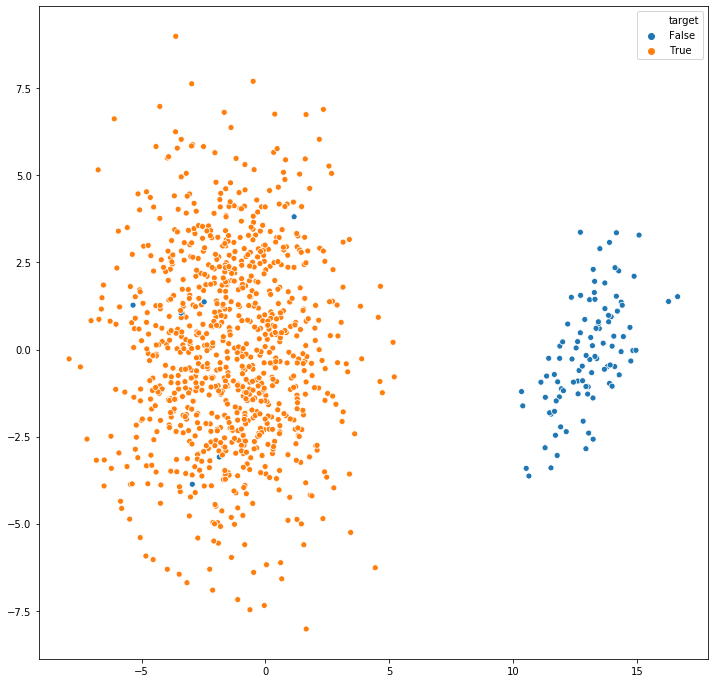

In [50]:
sns.scatterplot(imbalanced_pca[:, 0], imbalanced_pca[:, 1], hue=imbalanced.target);

Assim podemos ver claramente a maioria sendo da classe positiva (em laranja).

Utilizamos o SMOTE (do pacote `imblearn`) para reamostrar os dados da classe minoritária e assim balancear o _data set_:

In [51]:
smote = SMOTE(sampling_strategy="minority")

X_smote, y_smote = smote.fit_resample(imbalanced.iloc[:, :-1], imbalanced.target)

In [52]:
imbalanced_pca_smote = pca.transform(X_smote)

Agora podemos ver que existem mais dados da classe negativa (em azul) do que no _data set_ original:

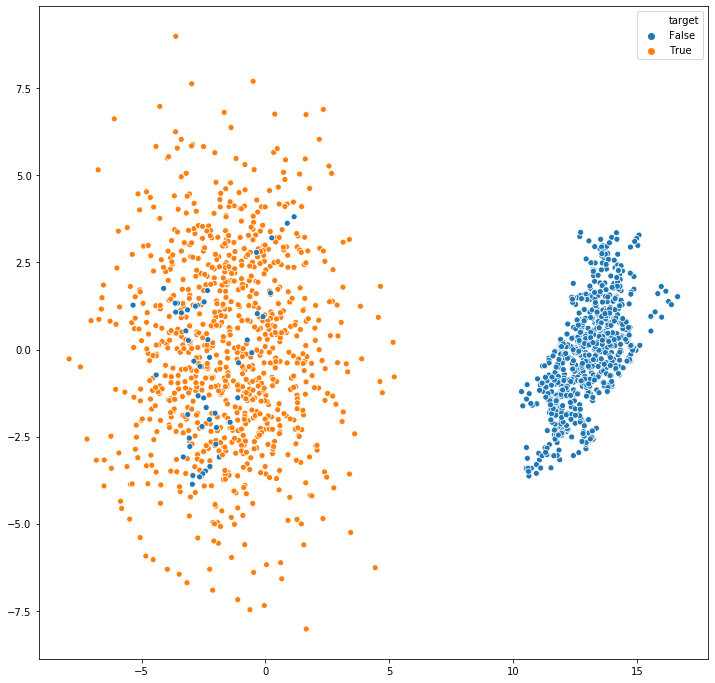

In [53]:
sns.scatterplot(x=imbalanced_pca_smote[:, 0], y=imbalanced_pca_smote[:, 1], hue=y_smote);

E a quantidade dados positivos e negativos se tornou igual:

In [73]:
sum(y_smote == True)/sum(y_smote == False)

1.0

## Criando _data set_ para classificação

Para os exemplos a seguir, vamos criar um _data set_ com 500 observações divididas em três classes:

In [55]:
X, y = make_blobs(n_samples=500, centers=3, cluster_std=2.0)

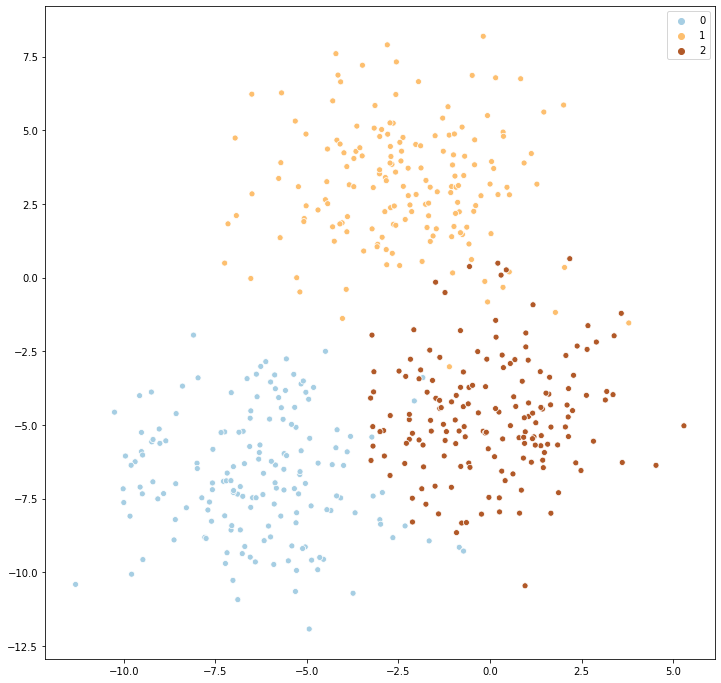

In [56]:
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette="Paired");

Para realizar o treinamento e teste dos modelos, vamos dividir o _data set_ criado em treinamento e teste numa razão de 4:1:

In [57]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape

(400, 2)

## Regressão logística

Agora veremos o nosso primeiro modelo de classificação: regressão logística. A regressão logística, apesar do nome, é um modelo de classificação bastante empregado em problemas de classificação binária.

Na regressão logística, a função regressanda é a probabilidade da observação ser da classe positiva, e sua forma é dada pela função logística, um pouco diferente das regressões que estamos habituados:

$$p(X) = \frac{e^{\beta_{0} + \beta_{1}X}}{1 + e^{\beta_{0} + \beta_{1}X}}$$

Como sabemos da regressão, isso não é um modelo linear nos parâmetros ($\beta_{0}$ e $\beta_{1}$), por isso não conseguimos estimá-lo dessa forma. No entanto, com algumas manipulações algébricas, conseguimos reduzir a equação acima a:

$$\ln{\frac{p(X)}{1 - p(X)}} = \beta_{0} + \beta_{1}X$$

Que é um modelo linear nos parâmetros! Agora podemos usar nosso conhecimento de regressão linear para estimar $\beta_{0}$ e $\beta_{1}$. Lembrando que utilizamos a proporção de dados na classe positiva como proxy para $p(X)$.

> Na verdade, os melhores estimadores para essa tarefa são dados por máxima verossimilhança (_Maximum Likelihood Estimators_ - MLE), mas pularemos essa parte.

![logistic](http://res.cloudinary.com/dyd911kmh/image/upload/f_auto,q_auto:best/v1534281070/linear_vs_logistic_regression_edxw03.png)

Importante notar que devido à função logística, o valor de $p(X)$ está limitado entre 0 e 1, o que é conveniente para representar uma probabilidade.

> Para o caso de múltiplas variáveis $X_{1}, X_{2}, \cdots, X_{k}$, basta substituir $\beta_{0} + \beta_{1}X$ por $\beta_{0} + \sum_{1 \leq i \leq k} \beta_{i} X_{i}$ nas equações anteriores, sem perda de generalidade.

Uma vez estimados $\beta_{0}$ e $\beta_{1}$, podemos fazer predições da probabilidade de $X$ ser da classe positiva utilizando a primeira equação mostrada. Se o valor de $p(X) \geq 0.5$, consideramos que existe uma maior probabilidade de $X$ pertencer à classe positiva ($Y = 1$). Caso contrário, ele pertence à classe negativa ($Y = 0$). Na verdade, podemos variar o valor limítrofe entre as classes como quisermos.

In [58]:
logistic = LogisticRegression()

logistic.fit(X_train, y_train)

LogisticRegression()

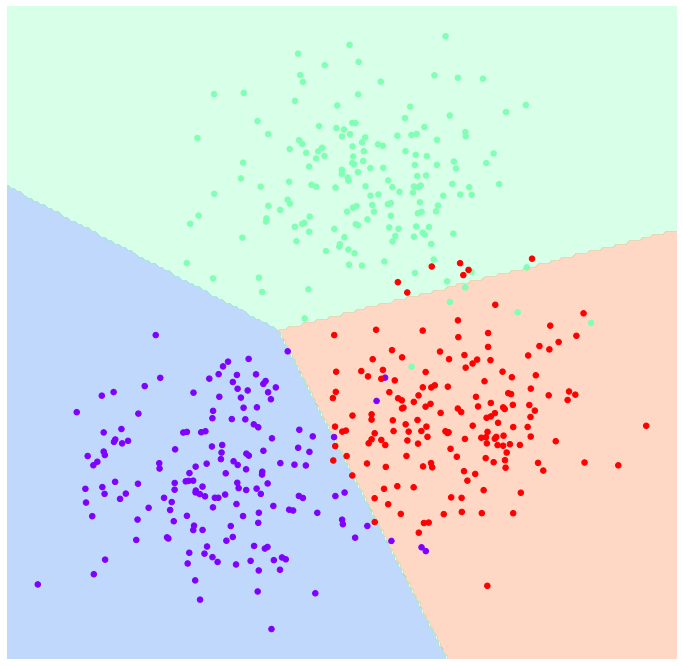

In [59]:
visualize_classifier(logistic, X, y)

Como a saída da regressão logística são probabilidades, é natural que o modelo tenha um método `predict_proba()` que nos retorne a probabilidade do dado de teste pertencer a cada uma das classes:

In [60]:
logistic.predict_proba([[-3, -2]])

array([[0.02623298, 0.23473261, 0.73903441]])

In [61]:
logistic.predict([[-3, -2]])

array([2])

A classe considerada como resposta é aquela que apresenta a maior probabilidade.

## $k$ _Nearest Neighbors_

O método kNN é bastante simples em suas ideia, mas muito poderoso em resultados, tanto teóricos, quanto práticos. Ao contrário da regressão logística, que é um método paramétrico, o kNN não utiliza nenhuma suposição sobre a distribuição das classes, sendo portanto um método __não__ paramétrico. Isso significa que nada precisa ser realmente treinado com o kNN: fazemos todas predições diretamente do conjunto de treinamento.

Pulando toda matemática envolvida, o kNN atribui a um ponto $X$ de teste a classe majoritária entre os $k$ pontos do conjunto de treinamento mais próximos a $X$. A proximidade aqui é geralmente medida em termos de distância Euclideana, mas outras métricas também são possíveis.

![knn](https://miro.medium.com/max/1300/0*Sk18h9op6uK9EpT8.)

Note que não é necessário treinar nenhum modelo geral para fazer a predição, bastam os dados de treinamento. Isso leva a uma fraqueza do método: é necessário manter em memória todo conjunto de treinamento para fazer predições. Métodos que utilizam modelos geralmente mantêm somente as informações do modelo em memória, o que exige bem menos.

O único parâmetro a ser determinado para uma melhor performance do classificador é o valor de $k$. Esse valor influencia fortemente nos resultados e a melhor forma de se escolher $k$ é através de métodos como cross-validation.

In [62]:
knn = KNeighborsClassifier(n_neighbors=7)

knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

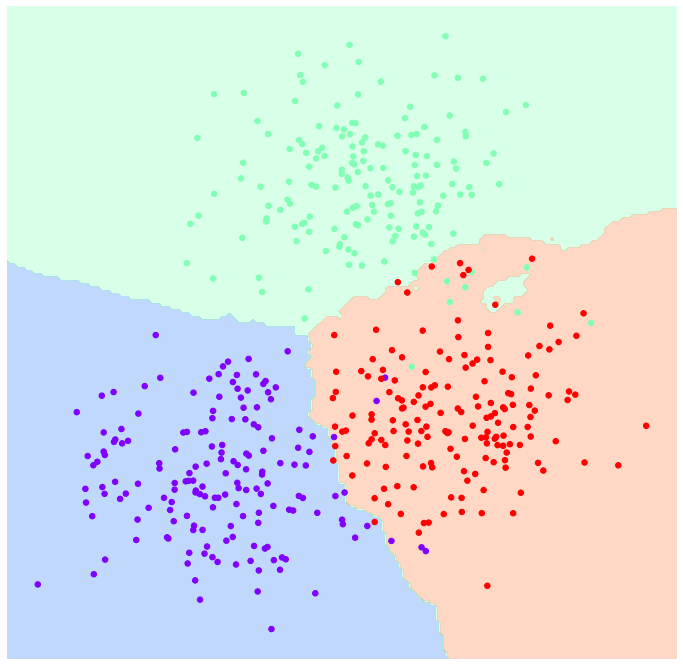

In [63]:
visualize_classifier(knn, X, y)

## Árvores de decisão

Árvores de decisão são algoritmos que podem ser usados tanto para regressão, quanto para classificação. Em geral, eles apresentam ótimo desempenho e são boas escolhas para criação de _ensembles_.

A ideia para seu treinamento, em alto nível, é bem básica: a cada passo, escolhemos uma variável e a dividimos em duas partes, dependendo de uma métrica como pureza. Repetimos esse passo recursivamente, criando uma árvore binária (cada nodo não folha tem dois filhos) até que tenhamos alcançado uma condição de parada (número máximo de folhas, ou de elementos em cada folha, ou profundida máxima da árvore etc).

![decision-tree](https://drive.google.com/uc?export=download&id=1fGeYNLedFWkn6bxdtljS3haJOZ10SoXb)

Considere a árvore de decisão acima, criada a partir do _data set_ Iris. O primeiro nodo começa separando os dados em dois grupos: aqueles cujo `petal_length` é menor que 2.45 cm e aqueles onde é maior. O filho à esquerda desse nodo (em laranja) é um nodo folha e representa uma classe final da árvore de decisão (no caso, _setosa_). Para as plantas cujo `petal_length` é maior que 2.45 cm, o nodo filho à direita (em branco) continua a divisão, agora considerando a variável `petal_width`. As plantas com `petal_length` maior que 2.45 e `petal_width` menor que 1.75 cm vão para o filho à esquerda (em verde), e as plantas com `petal_length` maior que 2.45 cm e `petal_width` maior que 1.75 cm vão para o filho à direita (em roxo). Os dois filhos são nodos folha e representam as classes _versicolor_ e _virginica_, respectivamente.

Após criada a árvore de decisão, é fácil fazer a predição para um dado de teste. Para isso, basta seguir todo caminho a partir da raiz da árvore, avaliando a cada nodo qual caminho seguir, dependendo das variáveis do dado de teste, até que se alcance um nodo folha.

Obviamente, qualquer um dos nodos da árvore não contém dados apenas de uma classe. Na verdade, existe uma mistura de classes em cada nodo, inclusive nas folhas.

O grau de mistura de classes em cada nodo é chamado de impureza. Existem algumas métricas de impureza que podemos usar, sendo as duas mais comuns o índice de Gini e a entropia.

O índice de Gini em um nodo $m$ é dado pela seguinte fórmula:

$$G_{m} = 1 - \sum_{1 \leq k \leq K} \hat{p}_{m,k}^{2}$$

onde $K$ é o número total de classes.

Estimamos $\hat{p}_{m,k}$ como a fração de dados da classe $k$ na região do espaço de _features_ delimitiado no nodo $m$.

Quanto mais próximo de zero o índice de Gini, maior a pureza. Em outras palavras, índices de Gini mais baixos representam regiões mais homogêneas.

Uma outra medida de impureza é a entropia, que é dada pela seguinte fórmula:

$$G_{m} = - \sum_{1 \leq k \leq K} \hat{p}_{m,k} \log_{2}{\hat{p}_{m,k}}$$

A entropia, apesar do sinal negativo, é sempre um valor positivo. Quanto mais alta, mais impureza (ou menos homogeneidade), há naquela região.

O índice de Gini tende a isolar classes mais frequentes em ramificações separadas da árvore, enquanto a entropia gera árvores mais balanceadas. No geral, elas não costumam apresentar essas diferenças, e levam à árvores muito semelhantes.


No exemplo abaixo, utilizamos o conjunto criado anteriormente para treinar uma árvore de decisão com profundidade máximo de 2.

In [64]:
decision_tree = DecisionTreeClassifier(max_depth=2)

decision_tree_fitted = decision_tree.fit(X_train, y_train)

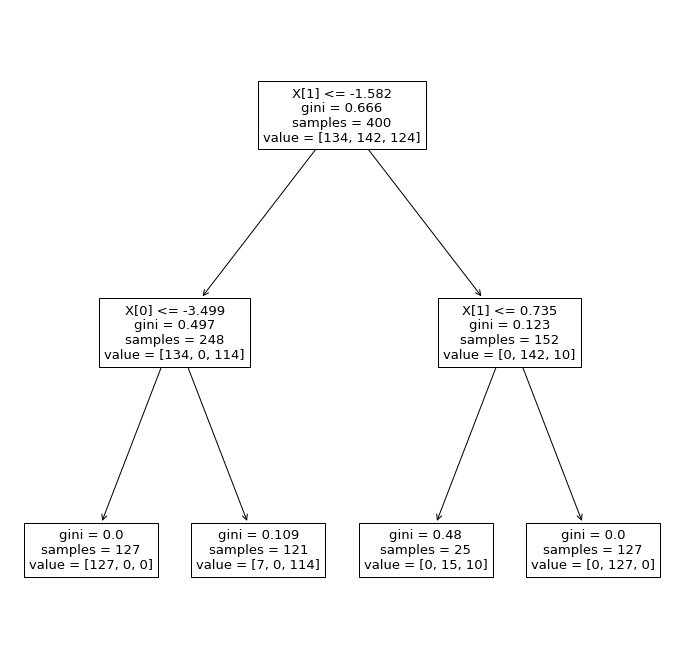

In [65]:
plot_tree(decision_tree_fitted);

Como podemos ver na árvore acima, a primeira folha tem índice de Gini igual a zero, o que significa que 100% dos dados que caíram nessa região durante o treinamento são todos da mesma classe. O mesmo acontece na última folha.

Abaixo verificamos as fronteiras de decisão da árvore criada:

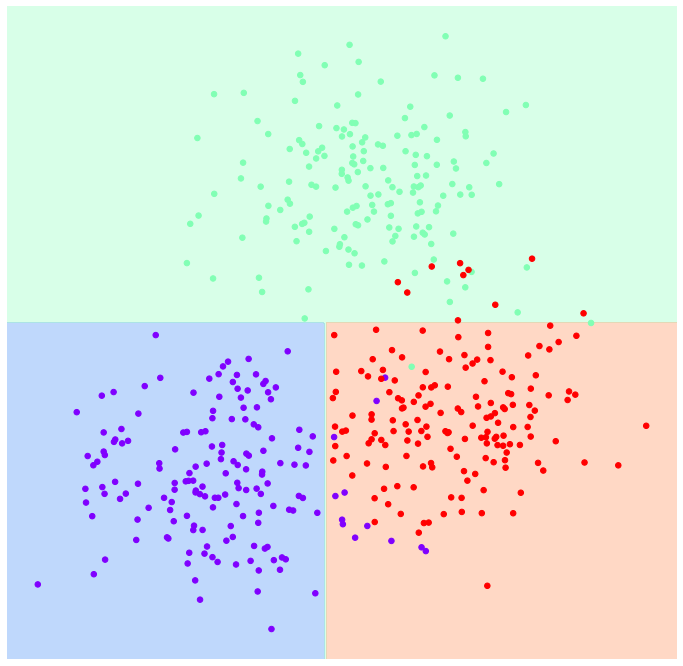

In [66]:
visualize_classifier(decision_tree, X, y);

Para prever em qual classe um dado de teste se encaixa, seguindo as regras da árvore de decisão, podemos utilizar o método `predict()`. Combinamos com o atributo `classes_` para identificar a classe exata:

In [67]:
print(f"(-6, -6): {decision_tree.classes_[decision_tree.predict([[-6, -6]])]}")
print(f"(-0, -6): {decision_tree.classes_[decision_tree.predict([[0, -6]])]}")
print(f"( 4,  6): {decision_tree.classes_[decision_tree.predict([[4, 6]])]}")

(-6, -6): [0]
(-0, -6): [2]
( 4,  6): [1]


Também é possível encontrar a probabilidade estimada do dado de teste se encaixar em qualquer uma das classes através do método `predict_proba()`:

In [68]:
decision_tree.predict_proba([[-4, -5]])

array([[1., 0., 0.]])

Árvores de decisão apresentam vantagens e desvantagens. Algumas vantagens:

* São fáceis de interpretar.
* Os dados não precisam ser pré-processados (normalização, padronização, nada disso).
* São não paramétricas, ou seja, não dependem de nenhuma suposição em relação aos dados.

Porém, também apresentam algumas desvantagens:

* Podem fazer _overfitting_ dos dados com certa facilidade.
* São muito suscetíveis a variações dos dados de treinamento.
* Não funcionam bem com _data sets_ desbalanceados.
* Dividem as regiões sempre de forma ortogonal.

## _Bagging_

Utilizar uma única árvore de decisão nem sempre leva a bons resultados. Árvores de decisão possuem uma alta variância e um baixo viés, o que pode levar a um alto erro total.

Para diminuir a variância, podemos utilizar _bootstrapping_. A técnica de _bootstraping_ consiste em reamostrar o conjunto de treinamento com reposição e treinar um modelo para cada uma das reamostragens. Após o treinamento dos vários modelos, podemos classificar um dado de teste simplesmente usando votação majoritária: a classe prevista pela maioria dos modelos é escolhida como classe final.

Importante notar que _bagging_ funciona com qualquer modelo de classificação. Mas é especialmente útil e popular com árvores de decisão.

Um exemplo de _bagging_ com 300 árvores de decisão, onde em cada árvore são escolhidos 100 dados do conjunto de treinamento, é mostrado abaixo:

In [69]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=300, max_samples=100, bootstrap=True)

bagging.fit(X_train, y_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_samples=100,
                  n_estimators=300)

As regiões encontradas pelo _ensemble_ final são mostradas abaixo. Note como as fronteiras de decisão são agora muito menos rígidas que aquelas encontradas por uma única árvore de decisão.

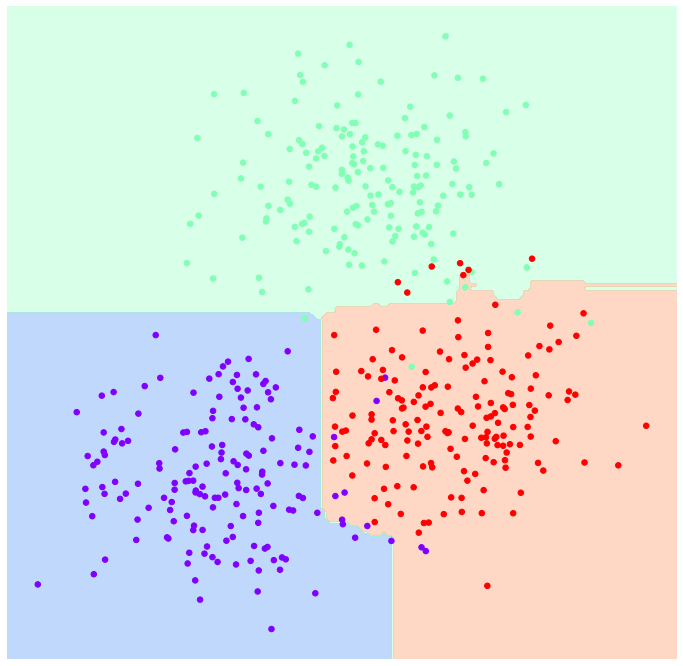

In [70]:
visualize_classifier(bagging, X, y);

Importante notar que ao fazermos _bagging_ (ou qualquer tipo de _ensemble_), abrimos mão da interpretabilidade do modelo. Enquanto uma árvore de decisão é um modelo altamente interpretável, um monte de árvores agindo ao mesmo tempo não é interpretável. Esse é um _tradeoff_ que temos que fazer entre interpretabilidade e desempenho.

## _Random forest_

Apesar de _bagging_ funcionar muito bem na maioria dos casos, podemos melhorá-lo ainda mais. A ideia das _random forests_ é subdividir também as _features_ usadas durante o treinamento das árvores de decisão.

A cada _split_ da árvore de decisão, apenas um subconjunto das _features_ é considerado. Isso ajuda a criar árvores mais variadas, ou seja, menos correlacionadas. Ao fazermos o _ensemble_ dessas árvores, temos um erro total ainda menor.

In [71]:
random_forest = RandomForestClassifier(n_estimators=500)

random_forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=500)

As regiões obtidas com _random forest_ são ainda mais flexíveis do que aquelas encontradas com _bagging_ simples:

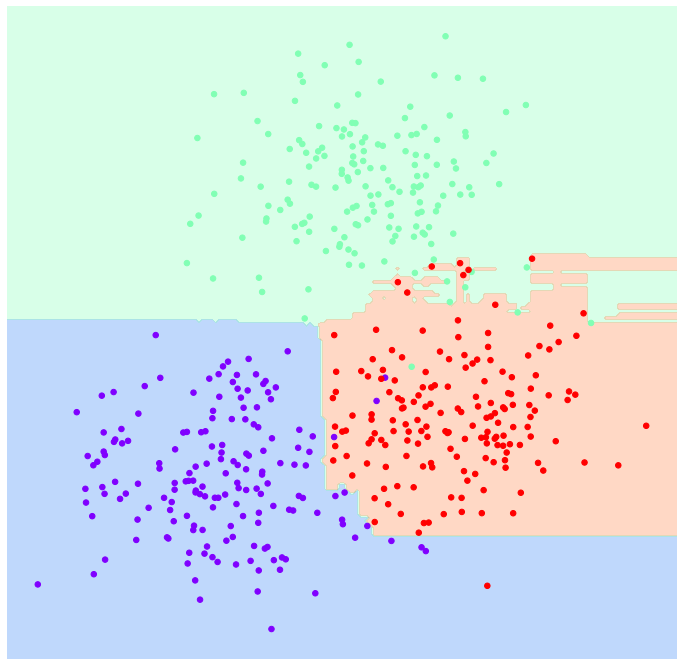

In [72]:
visualize_classifier(random_forest, X, y);

## Referências

* [Confusion matrix and other metrics in machine learning](https://medium.com/hugo-ferreiras-blog/confusion-matrix-and-other-metrics-in-machine-learning-894688cb1c0a)

* [Let’s learn about AUC ROC Curve!](https://medium.com/greyatom/lets-learn-about-auc-roc-curve-4a94b4d88152)

* [Classification Algorithms Comparison](https://www.kaggle.com/metetik/classification-algorithms-comparison)

* [Having an Imbalanced Dataset? Here Is How You Can Fix It.](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb)

* [SMOTE: Synthetic Minority Over-sampling Technique](https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb)

* [Foundations of Imbalanced Learning](https://pdfs.semanticscholar.org/1678/7e213ed0a5c0cf9baabdb45f9df631248a91.pdf)

* [Data Mining for Imbalanced Datasets: An Overview](https://www3.nd.edu/~dial/publications/chawla2005data.pdf)

* [An Introduction to Logistic Regression: From Basic Concepts to Interpretation with Particular Attention to Nursing Domain](https://pdfs.semanticscholar.org/3305/2b1d2363aee3ad290612109dcea0aed2a89e.pdf)

* [Explaining the Success of Nearest Neighbor Methods in Prediction](https://devavrat.mit.edu/wp-content/uploads/2018/03/nn_survey.pdf)

* [Classification: Basic Concepts, Decision Trees, and Model Evaluation](https://www-users.cs.umn.edu/~kumar001/dmbook/ch4.pdf)